### Using Documentation

Let's start by using the available documentation to pick a hardware injection we want to recover. From the S5 CBC hardware injection page, follow the link to the table of injections for H1. We'll pick an injection with a relatively high SNR for the tutorial. Scroll down until you see GPS time 817064899. You should see a line in the table that looks like this:

817064899 	H1 	10 	10 	25 	Successful 	28.16 	26.55 

### Getting Data


If you do not already know how to download and read a LIGO data file, you may want to start with the Introduction to LIGO Data Files. As a reminder, to download this data file, follow the menu link to Data & Catalogs to find the S5 Data Archive.
- Navigate to the [S5 Data Archive](https://losc.ligo.org/archive/S5)
- Select the H1 instrument
- Input the injection time as both the start and end of your query.
- Click submit

This should return a result with only the data file containing the injection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl
%matplotlib inline

In [2]:
strain, time, dq = rl.loaddata('H-H1_LOSC_4_V1-815411200-4096.hdf5')
dt = time[1] - time[0]
fs = 1.0 / dt
print(dq.keys())

dict_keys(['DATA', 'CBCHIGH_CAT1', 'CBCHIGH_CAT2', 'CBCHIGH_CAT3', 'CBCHIGH_CAT4', 'CBCLOW_CAT1', 'CBCLOW_CAT2', 'CBCLOW_CAT3', 'CBCLOW_CAT4', 'BURST_CAT1', 'BURST_CAT2', 'BURST_CAT3', 'BURST_CAT2E', 'BURST_CAT3E', 'CW_CAT1', 'STOCH_CAT1', 'STOCH_CAT2_H1L1', 'STOCH_CAT2_H2L1', 'PEM', 'HW', 'HW_CBC', 'HW_BURST', 'HW_STOCH', 'CW', 'DEFAULT'])


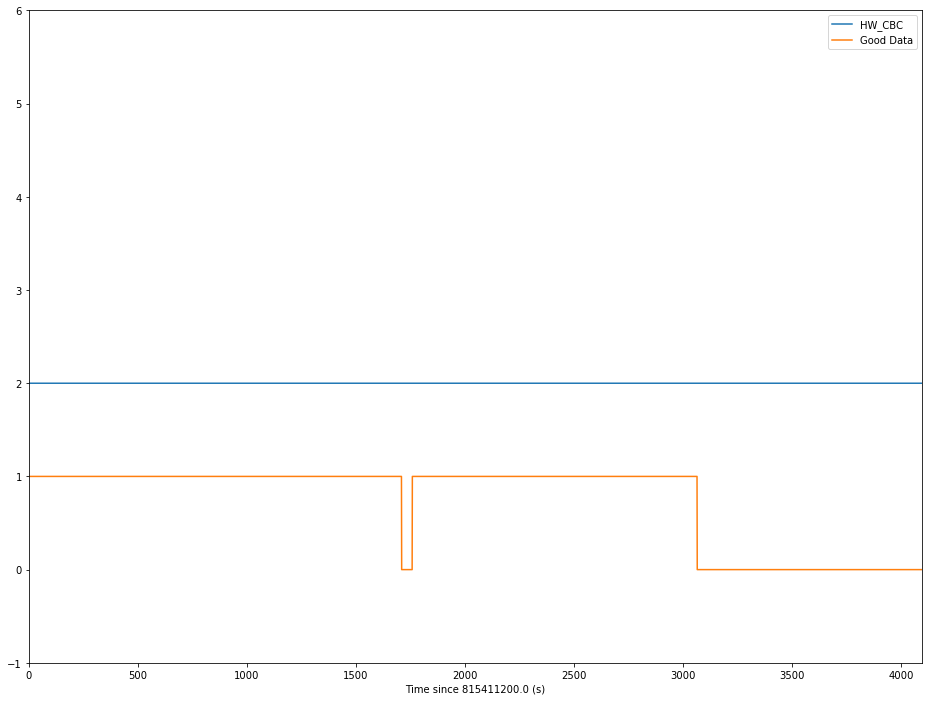

In [4]:
plt.figure(figsize=(16,12))
plt.plot(dq['HW_CBC'] + 2, label='HW_CBC')
plt.plot(dq['DEFAULT'], label='Good Data')
plt.xlabel('Time since ' + str(time[0]) + ' (s)')
plt.axis([0, 4096, -1, 6])
plt.legend()
plt.show()